In [13]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics

In [15]:
PATH = "Data/"

In [16]:
df_raw = pd.read_csv(f'{PATH}Train.csv', low_memory=False)

In [17]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [18]:
display_all(df_raw.tail())

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


In [19]:
df_raw = df_raw.drop(columns = ['Name'])

In [20]:
display_all(df_raw.describe(include='all'))

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,male,NaN,NaN,NaN,1601,NaN,B96 B98,S
freq,NaN,NaN,NaN,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [22]:
train_cats(df_raw)

In [21]:
display_all(df_raw.isnull().sum().sort_index()/len(df_raw))

Age            0.198653
Cabin          0.771044
Embarked       0.002245
Fare           0.000000
Parch          0.000000
PassengerId    0.000000
Pclass         0.000000
Sex            0.000000
SibSp          0.000000
Survived       0.000000
Ticket         0.000000
dtype: float64

In [23]:
df, y, nas = proc_df(df_raw, 'Survived')

In [24]:
df.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_na
0,1,3,2,22.0,1,0,524,7.2500,0,3,False
1,2,1,1,38.0,1,0,597,71.2833,82,1,False
2,3,3,1,26.0,0,0,670,7.9250,0,3,False
3,4,1,1,35.0,1,0,50,53.1000,56,3,False
4,5,3,2,35.0,0,0,473,8.0500,0,3,False


In [53]:
?proc_df

In [28]:
# imports for HPO
from hyperopt import hp
from hyperopt import fmin
from hyperopt import tpe
from hyperopt import Trials
from collections import OrderedDict
from sklearn.metrics import roc_auc_score

In [29]:
space = OrderedDict([('n_estimators', hp.choice('n_estimators', [20,50,100,200,500])),
                     ('max_features', hp.uniform('max_features', 0.1, 1.0)),
                     ('min_samples_leaf', hp.choice('min_samples_leaf', [1,2,3,5,8,13,21]))
                    ])

In [30]:
def objective(params):
    """Objective function to minimize"""

    m = RandomForestClassifier(n_jobs=-1, **params)
    m.fit(X_train, y_train)
    predictions = m.predict_proba(X_valid)

    return -(roc_auc_score(y_valid, predictions[:,1]))

In [28]:
?roc_auc_score

In [32]:
# re-run this cell only if want to reset HPO
trials = Trials()

In [36]:
tpe_best = None

tpe_best = fmin(fn=objective, space=space, algo=tpe.suggest, trials=trials, max_evals=150)
tpe_best

100%|██████████| 150/150 [00:57<00:00,  2.59trial/s, best loss: -0.9285024154589371]


{'max_features': 0.5223514632608875, 'min_samples_leaf': 1, 'n_estimators': 0}

In [39]:
m = RandomForestRegressor(max_features = .522351, min_samples_leaf = 1)
m.fit(X_train, y_train)
print_score(m)

[0.1390616721731825, 0.34556418613851325, 0.9188104710701485, 0.4777733057280883]


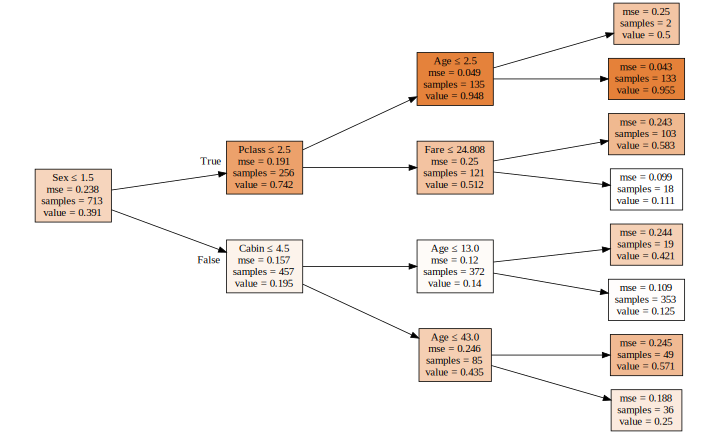

In [31]:
draw_tree(m.estimators_[0], df, precision=3)

In [54]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(df, y)
m.score(df,y)

0.9237763589301121

In [55]:
?RandomForestRegressor

In [34]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

n_valid = 178
n_trn = len(df)-n_valid
raw_train, raw_valid = split_vals(df_raw, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape

((713, 11), (713,), (178, 11))

In [35]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [27]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 257 ms, sys: 37.3 ms, total: 294 ms
Wall time: 139 ms
[0.14241653149546143, 0.4256462370339054, 0.9148458269329237, 0.20768256728778467]


In [28]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.14100470981759206, 0.4009840423847201, 0.9165257808499745, 0.29683734989648036]


In [29]:
preds = np.stack([t.predict(X_valid) for t in m.estimators_])
preds[:,0], np.mean(preds[:,0]), y_valid[0]

(array([1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1.,
        1., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1.]),
 0.41,
 0)

In [30]:
preds.shape

(100, 178)

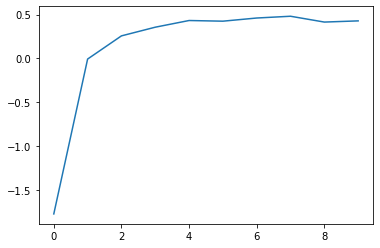

In [31]:
plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(10)]);

In [35]:
fi = rf_feat_importance(m, df); fi[:10]

,cols,imp
2,Sex,0.291692
6,Ticket,0.157490
0,PassengerId,0.130960
3,Age,0.117041
7,Fare,0.115626
1,Pclass,0.076423
8,Cabin,0.048089
4,SibSp,0.027089
9,Embarked,0.017865
5,Parch,0.011777


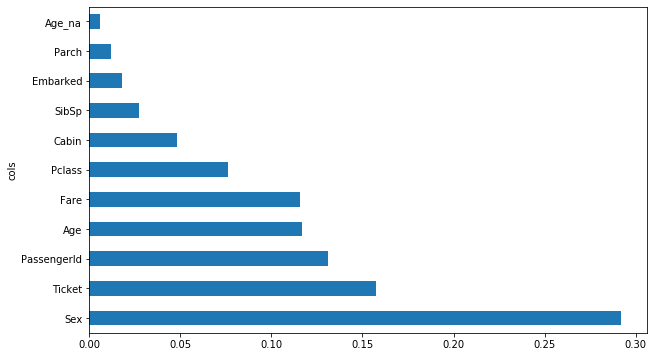

In [37]:
fi.plot.barh('cols', 'imp', figsize=(10,6), legend=False);

In [38]:
from scipy.cluster import hierarchy as hc

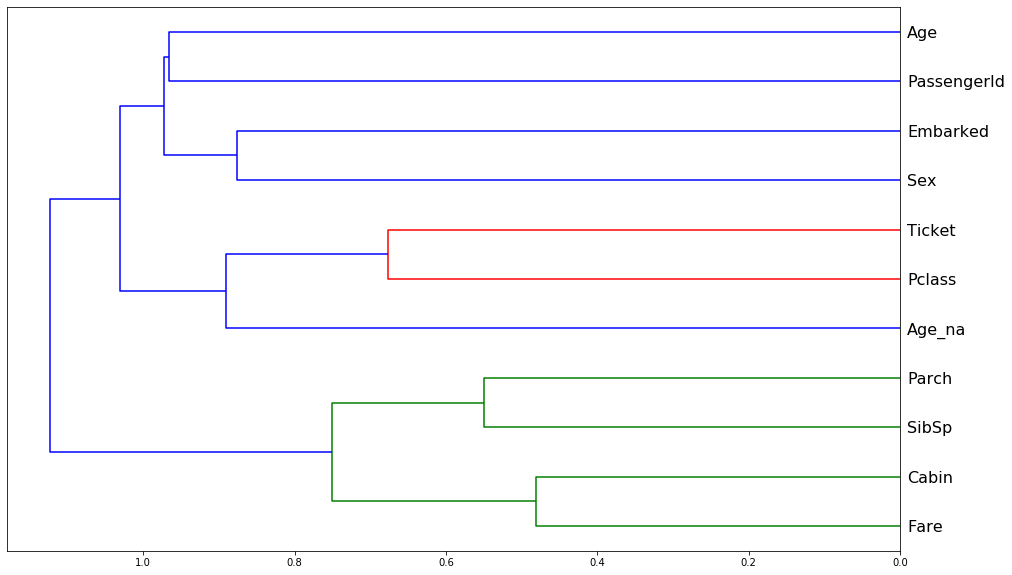

In [41]:
corr = np.round(scipy.stats.spearmanr(df).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df.columns, orientation='left', leaf_font_size=16)
plt.show()

In [42]:
display_all(df_raw.describe(include='all'))

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,male,NaN,NaN,NaN,CA. 2343,NaN,B96 B98,S
freq,NaN,NaN,NaN,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [43]:
df_test = pd.read_csv(f'{PATH}test.csv', low_memory=False)

In [44]:
df_test = df_test.drop(columns = ['Name'])

In [45]:
train_cats(df_raw)

In [46]:
df2, x, nas2 = proc_df(df_test, 'Survived')

KeyError: 'Survived'

In [47]:
display_all(df_test.describe(include='all'))

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,418.000000,418.000000,418,332.000000,418.000000,418.000000,418,417.000000,91,418
unique,NaN,NaN,2,NaN,NaN,NaN,363,NaN,76,3
top,NaN,NaN,male,NaN,NaN,NaN,PC 17608,NaN,B57 B59 B63 B66,S
freq,NaN,NaN,266,NaN,NaN,NaN,5,NaN,3,270
mean,1100.500000,2.265550,NaN,30.272590,0.447368,0.392344,NaN,35.627188,NaN,NaN
std,120.810458,0.841838,NaN,14.181209,0.896760,0.981429,NaN,55.907576,NaN,NaN
min,892.000000,1.000000,NaN,0.170000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,996.250000,1.000000,NaN,21.000000,0.000000,0.000000,NaN,7.895800,NaN,NaN
50%,1100.500000,3.000000,NaN,27.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,1204.750000,3.000000,NaN,39.000000,1.000000,0.000000,NaN,31.500000,NaN,NaN


In [40]:
df_ext = df.copy()
df_ext['is_valid'] = 1
df_ext.is_valid[:n_trn] = 0
x, y, nas = proc_df(df_ext, 'is_valid')

/Users/zionwang/opt/anaconda3/envs/test/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [41]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.9988776655443322

In [42]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
0,PassengerId,0.969661
6,Ticket,0.009029
3,Age,0.007048
7,Fare,0.006787
8,Cabin,0.002270
4,SibSp,0.002166
2,Sex,0.001175
5,Parch,0.000883
1,Pclass,0.000345
9,Embarked,0.000344


In [43]:
x.drop('PassengerId', axis=1, inplace=True)

In [44]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.7811447811447811

In [45]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
5,Ticket,0.326217
2,Age,0.247840
6,Fare,0.203182
7,Cabin,0.061643
1,Sex,0.046390
3,SibSp,0.031940
4,Parch,0.027631
8,Embarked,0.021121
0,Pclass,0.020536
9,Age_na,0.013500


In [46]:
feats = ['PassengerId', 'Ticket', 'Age', 'Fare', 'Cabin']

In [48]:
for f in feats:
    df_subs = df.drop(f, axis=1)
    X_train, X_valid = split_vals(df_subs, n_trn)
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(X_train, y_train)
    print(f)
    print_score(m)

PassengerId
[0.25813841753006866, 0.3137665059047291, 0.7202369116031195, 0.5694587397524838, 0.41787171772315157]
Ticket
[0.26116005531316516, 0.3308934624661432, 0.7136490483664141, 0.5211737088607649, 0.3919076185303231]
Age
[0.26153150679848625, 0.34376592136579764, 0.7128339074083837, 0.48319434431850894, 0.37876484832384016]
Fare
[0.2551690364357169, 0.3234481491232235, 0.7266361551168528, 0.5424790814843978, 0.3747619037326789]
Cabin
[0.2495256785834777, 0.32365506652670534, 0.738593960316061, 0.5418935204183495, 0.40330395380441153]


In [55]:
df_subs = df.drop('PassengerId', axis=1)
X_train, X_valid = split_vals(df_subs, n_trn)
m = RandomForestRegressor(min_samples_leaf=1, max_features=0.522, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.13940114354580949, 0.32344528738657524, 0.9184135944700461, 0.5424871773636991, 0.41478763104123495]


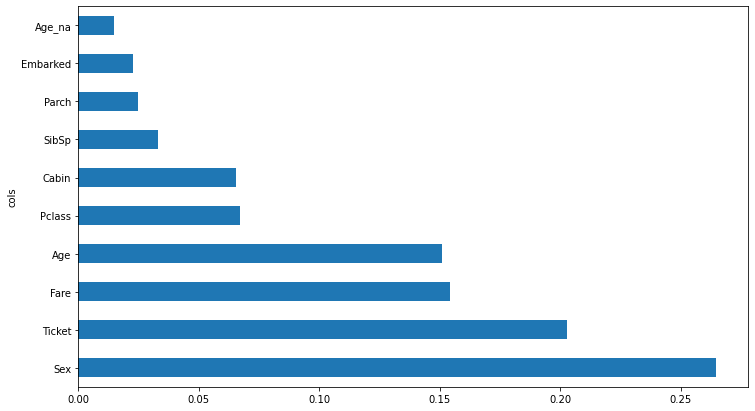

In [58]:
plot_fi(rf_feat_importance(m, X_train));

In [57]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)